
# Discrete Fourier Transform and Fast Fourier Transform

___

This Notebook gives a brief introduction to Discrete Fourier Transform (DFT) and the Fast Fourier Transform (FFT). The radix-2 Cooley-Tukey FFT algorithm is implemented and toward the end the physical meaning is explained.

These concepts have a wide area of applications in many different areas in both physics and mathematics, such as signal processing, sound and image filtering, data compression, partial differential equations and multiplication of large integers.

Before reading this notebook one should have an idea of what a Fourier transform and a Fourier series is, but it is not nessecery.

We start by importing the needed packages.

In [1]:
import numpy as np
import timeit
from scipy import fftpack as fft
from matplotlib import pyplot as plt

## Discrete Fourier Transform (DFT)

Let $\vec x = [x_0,x_1,...,x_{n-1}]$ be a vector with $n$ complex (or real) elements. The DFT of $\vec x$ is the complex vector $\vec y = [y_0,y_1,...,y_{n-1}]$, where the elements are defined as
$$y_k=\sum_{j=0}^{n-1}x_j\omega^{k\cdot j},$$
where $\omega = \exp(-2\pi i /n)$ ($i$ is the imaginary unit) [1]. 

## Physical meaning

The DFT maps a finite equally spaced sample sequence from its original domain to its frequency domain. In other words, a discrete time data set are transformed into a discrete frequency data set.

To illustrate this, we need to figure out what the DFT-formula physically means. We start by rewriting it as
$$x_k=\sum_{j=0}^{n-1}y_j\exp\left(2\pi i\frac{k}{n\Delta t}j\Delta t\right).$$
What the expression tells us is simply that $\vec x$ is a superposition of exponential functions with different frequencies $f_j = \frac{j}{n\Delta t}$ and amplitudes $y_j$. Therefore, we can view the magnitude of the amplitudes $|y_k|^2$ as a measure of the "weight of the frequency $f_j$" in $\vec x$!

In [2]:
def DFT(x):
    """ Calculates the one dimensional discrete Fourier transform of
    a vector.
    
    :x: double arr. The vector that is being transformed.
    :returns: double arr. The Fourier transform of x.
    """
    n = len(x)
    y = [0]*n
    omega = np.exp(-2.0j*np.pi/n)
    for k in range(0,n):
        y[k] = np.sum(x*omega**(np.arange(0,n)*k))
    return y

It is easy to realize that the inverse DFT is given by
$$x_k = \sum_{j=0}^{n-1} y_j\omega^{k\cdot j},$$
where $\omega = \exp(2\pi i/n)$.

In [3]:
def inverseDFT(y):
    """ Calculates the inverse one dimensional discrete Fourier
    transform of a vector.
    
    :y: double arr. The vector that is being transformed.
    :returns: double arr. The inverse Fourier transform of y.
    """
    n = len(y)
    x = [0]*n
    omega = np.exp(2.0j*np.pi/n)
    for k in range(0,n):
        x[k] = np.sum(y*omega**(np.arange(0,n)*k))/float(n)
    return x

Let us try with a small example where we simply transform and inverse transform a noisy periodic signal.

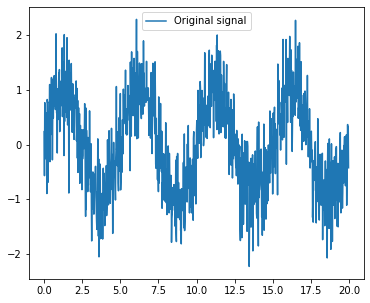

In [4]:
# Seed the random number generator
np.random.seed(1234)

time_step = 0.02
period = 5.

time_vec = np.arange(0, 20, time_step)
N = time_vec.shape[0]
sig = (np.sin(2 * np.pi / period * time_vec)
       + 0.5 * np.random.randn(time_vec.size))

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.legend()

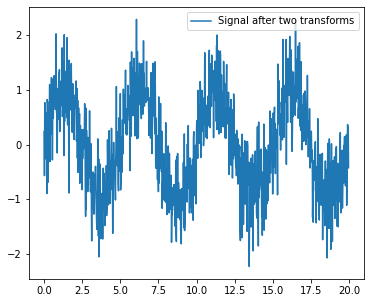

In [5]:
# The Fourier transform
sig_dft = DFT(sig)
# The invese Fourier transform. 
sig2 = inverseDFT(sig_dft)
plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Signal after two transforms')
plt.legend()

As you already might have noticed, this DFT-algorithm is quite inefficient. There are many subcalculations that are performed more than once, and as a consequence the complexity of this algorithm is $\mathcal O(n^2)$. 

## Fast Fourier Transform (FFT)
The FFT algorithms exploits symmetries and that many operations are similar. In this notebook we are going to discuss the Cooley–Tukey algorithm [2].

Assume that $N$ is composite. This means that $N=n_1\cdot n_2$, where $N$, $n_1$ and $n_2$ are integers. Rewrite the two indicies as 
$$k=n_2k_1+k_2,$$
$$j = n_1j_2 + j_1,$$
where $k_{1,2} = 0,1,...,n_{1,2}-1$ and $j_{1,2} = 0,1,...,j_{1,2}-1$. If we insert these new indicies into the DFT, some cross terms vanish, and the final result is
$$y_{n_2k_1+k_2}=\sum_{j_1=0}^{n_1-1}\sum_{j_2=0}^{n_2-1}x_{n_1j_2+n_1}\exp\left[\frac{-2\pi i}{n_1n_2}(n_1j_2+j_1)(n_2k_1+k_2)\right]$$
$$=\sum_{j_1=0}^{n_1-1}\exp\left[-\frac{2\pi i}{n}j_1k_2\right]\left(\sum_{j_2=0}^{n_2-1}x_{n_1j_2+j_1}\exp\left[-\frac{2\pi i}{n_2}j_2k_2\right]\right)\exp\left[-\frac{2\pi i}{n_1}j_1k_1\right].$$
In this equation each inner sum is a DFT of size $n_2$ and each outer sum is a DFT og size $n_1$. This yields a recursive formula for computing the DFT, which is explained in more detail in [1] and [4]. For simplicity, let us use the radix-2 algorithm. The complexity of the FFT algorithm is $\mathcal O (n\log n)$, which makes it almost linear for large data sets!

In [6]:
def CooleyTukeyRadix2FFT(x):
    """ Calculates the one dimensional discrete Fourier transform of
    a vector using the radix-2 Cooley-Tukey FFT algorithm. The vector
    that is being transformed must have a power of 2 number of elements.
    
    :x: double arr. The vector that is being transformed.
    :returns: double arr. The Fourier transform of x.
    """
    # Check if n is a power of 2.
    if ( len(x) & (len(x) - 1)):
        raise Exception("The number of elements in x has to be a power of 2!")
    # Recursive formula for calculating the FFT.
    def foo(x):
        n = len(x)
        if n == 1:
            y = x
        else:
            y2 = foo(x[0:n:2])
            y1 = foo(x[1:n + 1:2])
            d = np.exp(-2j*np.pi/n)**np.arange(0,n/2)
            y = np.append(y2 + d*y1,y2 - d*y1)
        return y
    return foo(x)

def inverseCooleyTukeyRadix2FFT(y):
    """ Calculates the one-dimensional inverse discrete Fourier transform of
    a vector using the radix-2 Cooley-Tukey FFT algorithm. The vector
    that is being transformed must have a power of 2 number of elements.
    Parameters:
        x: double arr. The vector that is being transformed.
    Returns:
        y: double arr. The Fourier transform of x.
    """
    # Check if n is a power of 2.
    if (len(y) & (len(y) - 1)):
        raise Exception("The number of elements in x has to be a power of 2!")
    # Recursive formula for calculating the FFT.
    def foo(y):
        n = len(y)
        if n == 1:
            x = y
        else:
            x2 = foo(y[0:n:2])
            x1 = foo(y[1:n + 1:2])
            d = np.exp(2j*np.pi/n)**np.arange(0,n/2)
            x = np.append(x2 + d*x1,x2 - d*x1)
        return x
    return foo(y)/len(y)

Let us try with a small example where we simply transform and inverse transform an arbitrary vector as before.

In [7]:
# Defining the array that is being transformed.
# input needs to have 2**N elements
x = sig[:512]
# The Fourier transform.
y = CooleyTukeyRadix2FFT(x)
# The invese Fourier transform. 
x = inverseCooleyTukeyRadix2FFT(y)


To demonstrate the superiority of the FFT we calculate the Fourier transform of a lot bigger data set. Let us also compare with the fft function from scipy.fftpack.

In [ ]:
# Time the loop time for DFT, CooleyTukeyRadix2FFT and scipy.fftpack.fft.
%timeit y = DFT(x)
%timeit y = CooleyTukeyRadix2FFT(x)
%timeit y = fft.fft(x)

35.9 ms ± 889 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Signal Processing with `fftpack`

In [ ]:
# The FFT of the signal
sig_fft = fft.fft(sig)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)**2

# The corresponding frequencies
sample_freq = fft.fftfreq(sig.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])

# scipy.signal.find_peaks_cwt can also be used for more advanced
# peak detection

Remove all the high frequencies
###########################################################

 We now remove all the high frequencies and transform back from
 frequencies to signal.



In [ ]:
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
filtered_sig = fft.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')

**Note** This is actually a bad way of creating a filter: such brutal
cut-off in frequency space does not control distorsion on the signal.

Filters should be created using the scipy filter design code


## Multidimensional DFT
Let $\vec j = (j_1,j_2,...,j_d)$ and $\vec k = (k_1,k_2,...,k_d)$ be $d$-dimensional vectors of indicies from $\vec 0$ to $\vec n-1 = (n_1-1,n_2,...,n_d-1)$. Then, the $d$-dimensinal DFT is given by
$$y_\vec{k}=\sum_{\vec j=\vec 0}^{\vec n-1}x_\vec{j}\exp\left[-2\pi\vec k\cdot\vec \xi\right],$$
where $\vec \xi$ is the elementwise division $(j_1/n_1,...,j_d/n_d)$ [4]. For example, the two dimensional DFT is given by
$$\vec y_{k_1,k_2}=\sum_{j_1=0}^{n_1-1}\sum_{j_2=0}^{n_2-1}x_{j_1,j_2}\exp\left[-2\pi i\left(\frac{ k_1j_1}{n_1}+\frac{k_2j_2}{n_2}\right)\right].$$

The `fftpack` module in `scipy` implements multidimensional FFTs as

    fft2(x[, shape, axes, overwrite_x])  2D FFT
    ifft2(x[, shape, axes, overwrite_x]) 2D inverse-FFT
    fftn(x[, shape, axes, overwrite_x])  n-D FFT
    ifftn(x[, shape, axes, overwrite_x]) n-D inverse-FFT

References:  
[1] T. Sauer: Numerical Analysis, second edition, Pearson 2014  
[2] James W. Cooley and John W. Tukey: An Algorithm for the Machine Calculation of Complex Fourier Series, Math. Comp. 19 (1965), p. 297-301  
[3] Wikipedia: https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm, 03.28.2016 (acquired: April 2016)  
[4] Wikipedia: https://en.wikipedia.org/wiki/Discrete_Fourier_transform, 04.28.2016 (acquired: April 2016)

Check out the FFT pack in SciPy:
http://docs.scipy.org/doc/scipy/reference/fftpack.html  